# Vegetable and fruit detection

Project for Image and Speech Recognition course carried out at Warsaw University of Technology in 2021/2022 academic year.

Authors:
- Flávio Maia
- Abbaszade Kamran
- Piotr Pilis

#Easy Testing

For easy testing of the models download the weights and data from https://file.io/iFBy1hgFmpl8. Upload the extracted files and run. 

In [ ]:
!unzip IASR_weights_and_data.zip

## Import Python libraries

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
random.seed(123)

import numpy as np
import pandas as pd
import torch
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import sklearn.metrics as skmetrics
from google.colab.patches import cv2_imshow
from PIL import Image
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from sklearn.model_selection import train_test_split

## First Dataset

In [ ]:
FRUIT360_LABELS = ['Cauliflower', 'Plum 2', 'Potato Sweet', 'Pear Kaiser', 'Clementine', 'Pineapple Mini', 'Cocos', 'Tomato Maroon', 'Granadilla', 'Apple Golden 1', 'Grape White', 'Plum 3', 'Pear Forelle', 'Pineapple', 'Pepper Yellow', 'Banana Red', 'Cherry Wax Yellow', 'Apple Crimson Snow', 'Rambutan', 'Cherry 2']

def deepwidebn_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (7,7), stride=(2,2), padding=(3,3)),
      torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1),  padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(64, output_size),
  ).train()

path = os.getcwd() + 'IASR_weights_and_data/m_deepwidebn_conv_fruits360.pt'

m_deepwidebn_conv = deepwidebn_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_deepwidebn_conv.load_state_dict(torch.load(path))
_ = m_deepwidebn_conv.eval()

In [ ]:
def evaluate(fruit_path):
  pil_image = Image.open(fruit_path)
  display(pil_image)
  default_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(50),
    tv.transforms.CenterCrop(50)                                   
  ])
  transformed_data = default_transforms(pil_image).to('cuda').unsqueeze(0)
  output = m_deepwidebn_conv(transformed_data)
  label_prediction = FRUIT360_LABELS[np.argmax(output.detach().to('cpu')).item()]
  print('Predicted label: ' + label_prediction)
  


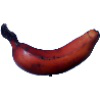

Predicted label: Banana Red


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits360/160_100.jpg'
evaluate(fruit_path)

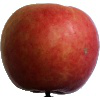

Predicted label: Apple Crimson Snow


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits360/123_100.jpg'
evaluate(fruit_path)

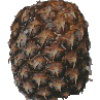

Predicted label: Pineapple


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits360/177_100.jpg'
evaluate(fruit_path)

##Second Dataset

In [ ]:
FRUIT262_LABELS = ['orange', 'raspberry', 'coffee', 'pear', 'clementine', 'pineapple', 'cashew', 'apple', 'mango', 'cranberry']

def resnet_pretrained(output_size=3):
  return torch.nn.Sequential(
    models.resnet18(pretrained=True),
    torch.nn.Linear(1000, output_size),
    ).train()

path = os.getcwd() + 'IASR_weights_and_data/m_resnet_pretrained_fruits262.pt'


m_resnet_pretrained = resnet_pretrained(output_size=len(FRUIT262_LABELS)).to('cuda')
m_resnet_pretrained.load_state_dict(torch.load(path))
_ = m_resnet_pretrained.eval()

In [ ]:
def evaluate(fruit_path):
  pil_image = Image.open(fruit_path)
  display(pil_image)
  default_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(100),
    tv.transforms.CenterCrop(100),
  ])  
  transformed_data = default_transforms(pil_image).to('cuda').unsqueeze(0)
  output = m_resnet_pretrained(transformed_data)
  label_prediction = FRUIT262_LABELS[np.argmax(output.detach().to('cpu')).item()]
  print('Predicted label: ' + label_prediction)

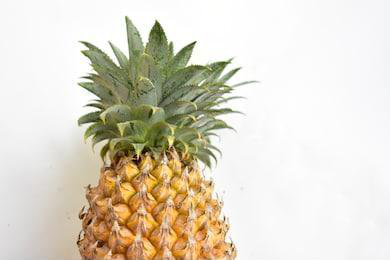

Predicted label: pineapple


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits262/1.jpg'
evaluate(fruit_path)

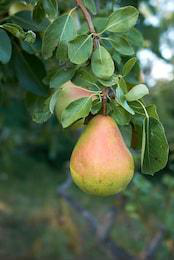

Predicted label: pear


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits262/107.jpg'
evaluate(fruit_path)

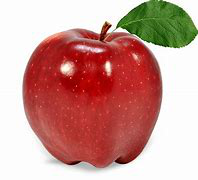

Predicted label: apple


In [ ]:
fruit_path = os.getcwd() + 'IASR_weights_and_data/fruits262/0.jpg'
evaluate(fruit_path)

# Getting started

## Give access to Google Drive

It means giving access to the files in your google drive to Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initializing Kaggle CLI

Download the Kaggle API token:
1. Go to “Account”, go down the page, and find the “API” section.
2. Click the “Create New API Token” button.
3. The “kaggle.json” file will be downloaded.
4. **Upload "kaggle.json" to your Google Drive to "Colab Notebooks/Kaggle" directory.**

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Import Python libraries

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
random.seed(123)

import numpy as np
import pandas as pd
import torch
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import sklearn.metrics as skmetrics
from google.colab.patches import cv2_imshow
from PIL import Image
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# First Dataset - Fruits 360 (moltean)

Source: https://www.kaggle.com/moltean/fruits

## Data Preparation

In [ ]:
FRUIT360_TRAIN_DIR = os.getcwd() + '/fruits-360_dataset/fruits-360/Training'
FRUIT360_TEST_DIR = os.getcwd() + '/fruits-360_dataset/fruits-360/Test'
FRUIT360_LABELS = ['Cauliflower', 'Plum 2', 'Potato Sweet', 'Pear Kaiser', 'Clementine', 'Pineapple Mini', 'Cocos', 'Tomato Maroon', 'Granadilla', 'Apple Golden 1', 'Grape White', 'Plum 3', 'Pear Forelle', 'Pineapple', 'Pepper Yellow', 'Banana Red', 'Cherry Wax Yellow', 'Apple Crimson Snow', 'Rambutan', 'Cherry 2']

### Downloading data from Kaggle

In [ ]:
!kaggle datasets download moltean/fruits
!unzip fruits.zip

### Preparation 

In [ ]:
default_transforms = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Resize(50),
  tv.transforms.CenterCrop(50)                                   
])

class Fruit360(torch.utils.data.Dataset):
  def __init__(
    self,
    path,
    labels,
    transforms=default_transforms
  ):
    super(Fruit360, self).__init__()

    self.path = path
    self.transforms = transforms
    self.labels = labels

    # Traverse raw data directories and build file paths and file labels
    self.file_paths = sum([ [ path + '/' + label + '/' + filename for filename in sorted(os.listdir(path + '/' + label)) ] for label in labels ], [])
    self.file_labels = sum([ [ label for filename in sorted(os.listdir(path + '/' + label)) ] for label in labels ], [])
    
    # Cache number of files
    self.len = len(self.file_paths)

  def __getitem__(self, idx):
    image_raw = Image.open(self.file_paths[idx])
    image_transformed = self.transforms(image_raw)
    return image_transformed, self.labels.index(self.file_labels[idx])
    
  def __len__(self):
    return self.len

Instantiate Fruit360 dataset

In [ ]:
fruit360_train = Fruit360(FRUIT360_TRAIN_DIR, FRUIT360_LABELS)
fruit360_test = Fruit360(FRUIT360_TEST_DIR, FRUIT360_LABELS)

In [ ]:
print(len(fruit360_train))
print(len(fruit360_test))

10586
3556


Utility function used to preview dataset images

In [ ]:
def plot_image_grid(images, nb_rows, nb_cols, num_classes, figsize=(15, 15)):
  fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
  
  n = 0
  for i in range(0, nb_rows):
    for j in range(0, nb_cols):
      axs[i, j].axis('off')
      axs[i, j].imshow(images[ (i * int(len(images) / num_classes) + j ) ][0].permute(1,2,0))
      n += 1

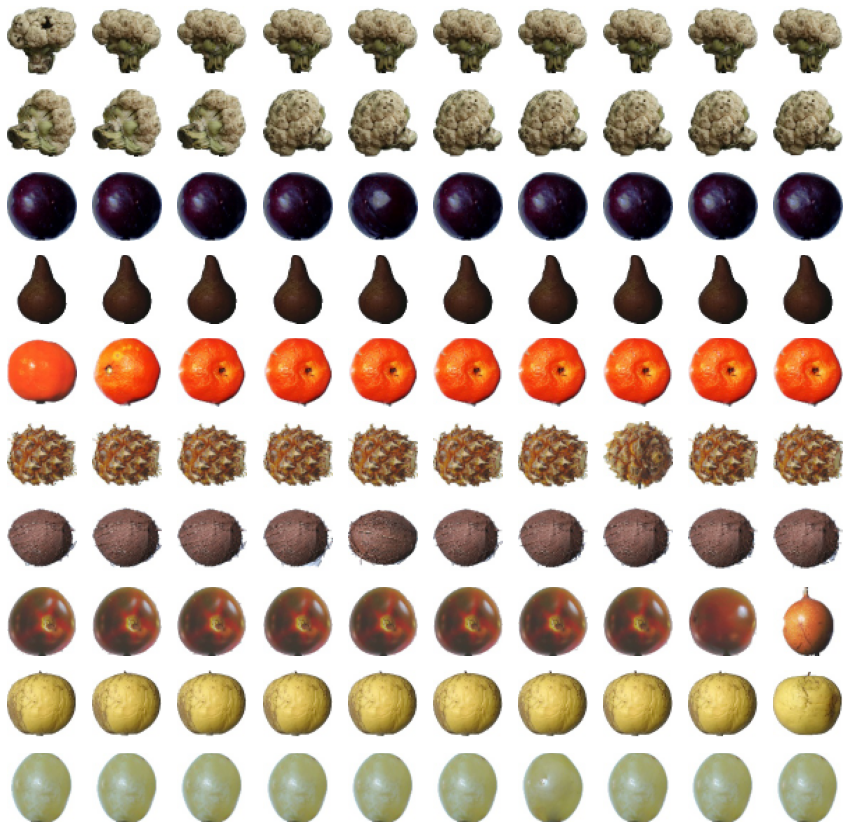

In [ ]:
plot_image_grid(fruit360_train, 10, 10, len(FRUIT360_LABELS))

## Classification using standard methods



### Feature extraction

In [ ]:
def apply_feature_extraction(func, dataset_train, dataset_test):
  def apply(dataset):
    features = []
    labels = []

    for image, label in dataset:
      image_scaled = (image * 256).int()
      
      features.append(func(image_scaled))
      labels.append(label)
    
    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, labels

  dataset_train_features, dataset_train_labels = apply(dataset_train)
  dataset_test_features, dataset_test_labels = apply(dataset_test)

  return dataset_train_features, dataset_train_labels, dataset_test_features, dataset_test_labels

#### PCA

In [ ]:
def transform_image_to_feature_vector(dataset):
  features = []
  labels = []

  for image, label in dataset:
    features.append(((image * 256).int()).reshape(-1))
    labels.append(label)

  features = np.vstack(features)
  labels = np.vstack(labels)

  return features, labels

##### Scikit-learn impelementation

In [ ]:
images_train, labels_train = transform_image_to_feature_vector(fruit360_train)

In [ ]:
images_test, labels_test = transform_image_to_feature_vector(fruit360_test)

In [ ]:
print(images_train.shape)
print(images_test.shape)

In [ ]:
pca = PCA(n_components=50)
pca_train = pca.fit_transform(images_train)
pca_test = pca.transform(images_test)

In [ ]:
print(pca_train.shape)
print(pca_test.shape)
print(sum(pca.explained_variance_ratio_))

In [ ]:
inverse = pca.inverse_transform(pca_train)

In [ ]:
def plot_pca_grid(images, nb_rows, nb_cols, num_classes, figsize=(15, 15)):
  fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
  
  n = 0
  for i in range(0, nb_rows):
    for j in range(0, nb_cols):
      axs[i, j].axis('off')
      axs[i, j].imshow((inverse[random.randint(0,len(images))].reshape(3, 50, 50).transpose(1, 2, 0) / 256))
      n += 1 

In [ ]:
plot_pca_grid(inverse, 5, 5, 20)

##### Custom implementation

Training algorithm:
1. Standardize all columns by substracting element from column mean and dividing by standard deviation
2. Calculate covariance matrix - contains information about the amount of variance shared between pairs of variables
3. Compute eigenvectors and eigenvalues of covariance matrix
4. Select eigenvectors that explain at least 95% of variance of data
5. Compute and return projection matrix

Fitting raw features to PCA means to compute dot product between raw features times projection matrix

In [ ]:
def standardize(X):
  rows, columns = X.shape

  standardized = np.zeros(shape=X.shape)
  tmp = np.zeros(rows)

  for column in range(columns):
    mean = np.mean(X[:,column])
    std = np.std(X[:,column])
    tmp = np.empty(0)

    for element in X[:,column]:
      tmp = np.append(tmp, ((element - mean) / std))

    standardized[:,column] = tmp
  return standardized

def custom_PCA_train(dataset, threshold=95):
  X = np.array(dataset)
  X_standardized = standardize(X)

  # Create nxn array where n is number of parameters describing image
  # For images 100x100 number of parameters is 100x100x3 = 30000
  # which crash Colab runtime due to insufficient RAM hence I decided to
  # lower resultion of image to 50x50
  covariance_matrix = np.cov(X.T)

  # Eigenvectors are the principal components
  eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

  # Select eigenvectors that explain at least "threshold" of variance of data
  variance_explained = []
  for eigen_value in eigen_values:
    variance_explained.append((eigen_value / sum(eigen_values)) * 100)
  cumulative_variance_explained = np.cumsum(variance_explained)
  min_value = min([i for i in cumulative_variance_explained if i > threshold])
  min_idx = np.where(eigen_values == min_value)

  # Compute projection matrix
  projection_matrix = (eigen_vectors.T[:][:2]).T

  return projection_matrix

def custom_PCA_fit(dataset, projection_matrix):
  X = np.array(dataset)

  return X.dot(projection_matrix)


In [ ]:
custom_PCA_dataset_test = images_test[0:3,:]
custom_PCA_dataset_test

Performance of custom implementation is much worse than scikit-learn one.

Custom solution has bottleneck on solving eigenvectors and eignevalues for covariance matrix of shape 7500 x 7500 with `np.linalg.eig(covariance_matrix)`

Execution takes ~3 minutes.

In [ ]:
projection_matrix = custom_PCA_train(custom_PCA_dataset_test)
dataset_pca = custom_PCA_fit(custom_PCA_dataset_test, projection_matrix)

print(projection_matrix)
print(dataset_pca)

#### Color Histogram

Compute histogram for each color channel

In [ ]:
def get_color_histogram(image, bins=256, range=(0, 256)):
  channels = ['red', 'green', 'blue']
  histograms = []
  for idx, channel in enumerate(channels):
    histogram, _ = np.histogram( image[:, :, idx], bins=256, range=(0, 256) )
    histograms.append(histogram)

  return np.hstack(histograms)

In [ ]:
fruit360_train_ch_features, fruit360_train_ch_labels, fruit360_test_ch_features, fruit360_test_ch_labels = apply_feature_extraction(get_color_histogram, fruit360_train, fruit360_test)

In [ ]:
print(fruit360_train_ch_features.shape)
print(fruit360_test_ch_features.shape)

#### Histogram of Oriented Gradients

HOG is an image feature descriptor describing the image based on the gradient directions and magnitudes.

Intuition: We know that edges and corners pack in a lot more information about object shape than flat regions

##### Skimage implementation

In [ ]:
def scikit_hog(image):
  image = image.numpy().transpose(1, 2, 0).astype('uint8')
  feature, viz = hog(image, orientations=8, pixels_per_cell=(10, 10), cells_per_block=(1, 1), visualize=True)
  return feature

fruit360_train_hog_features, fruit360_train_hog_labels, fruit360_test_hog_features, fruit360_test_hog_labels = apply_feature_extraction(scikit_hog, fruit360_train, fruit360_test)

In [ ]:
print(fruit360_train_hog_features.shape)
print(fruit360_test_hog_features.shape)

##### Custom implementation

Algorithm overview:
1. Calculate gradient for surrounding of each pixel (multiplication of 3x1 region times mask)
2. Calculate image gradient magnitude and direction
3. Chunk image into 8x8 blocks and compute cell histogram
4. Normalize by 16x16 blocks (to be done)
5. Calculate the Histogram of Oriented Gradients feature vector (to be done)

In [ ]:
def custom_hog(image_grayscale):
  # Compute horizontal and vertical mask
  HORIZONTAL_MASK = np.array([-1, 0, 1])
  VERTICAL_MASK = np.array([-1, 0, 1]).T

  def calculate_gradient(image, mask):
    # Mask need to applied at edges so we need to add padding of mask size to each edge
    image_padded = np.zeros((image.shape[0] + mask.size - 1, image.shape[1] + mask.size - 1))
    # Place input image at the center of image_paddded
    padding = np.uint16((mask.size - 1) / 2.0)
    image_padded[padding:image.shape[0] + padding, padding:image.shape[1] + padding] = image

    # Create output image
    result = np.zeros((image_padded.shape))
    
    for row in np.uint16(np.arange(padding, image.shape[0] + padding)):
      for column in np.uint16(np.arange(padding, image.shape[1] + padding)):
          curr_region = image_padded[row - padding:row + padding + 1, column - padding:column + padding + 1]
          curr_result = curr_region * mask
          score = np.sum(curr_result)
          result[row, column] = score

    # Result of the same size as the original image after removing the padding
    result_img = result[padding:result.shape[0] - padding, padding:result.shape[1] - padding]
    return result_img

  def calculate_gradient_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = np.power(horizontal_gradient, 2)
    vertical_gradient_square = np.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    gradient_magnitude = np.sqrt(sum_squares)
    return gradient_magnitude

  def calculate_gradient_direction(horizontal_gradient, vertical_gradient):
    EPSILON = 0.00000001
    gradient_direction = np.arctan(vertical_gradient / (horizontal_gradient + EPSILON))
    gradient_direction = np.rad2deg(gradient_direction)
    gradient_direction = gradient_direction % 180
    return gradient_direction

  def get_cell_histogram(cell_magnitude, cell_direction, histogram_bins=np.array([10,30,50,70,90,110,130,150,170])):
    cell_histogram = np.zeros(shape=(histogram_bins.size))
    cell_size = cell_direction.shape[0]

    for row_idx in range(cell_size):
      for column_idx in range(cell_size):
        curr_direction = cell_direction[row_idx, column_idx]
        curr_magnitude = cell_magnitude[row_idx, column_idx]

        diff = np.abs(curr_direction - histogram_bins)

        if curr_direction < histogram_bins[0]:
          first_bin_idx = 0
          second_bin_idx = histogram_bins.size - 1
        elif curr_direction > histogram_bins[-1]:
          first_bin_idx = histogram_bins.size - 1
          second_bin_idx = 0
        else:
          first_bin_idx = np.where(diff == np.min(diff))[0][0]
          temp = histogram_bins[[(first_bin_idx - 1) % histogram_bins.size, (first_bin_idx + 1) % histogram_bins.size]]
          temp2 = np.abs(curr_direction - temp)
          res = np.where(temp2 == np.min(temp2))[0][0]
          if res == 0 and first_bin_idx != 0:
            second_bin_idx = first_bin_idx - 1
          else:
            second_bin_idx = first_bin_idx + 1

        first_bin_value = histogram_bins[first_bin_idx]
        second_bin_value = histogram_bins[second_bin_idx]

        cell_histogram[first_bin_idx] = cell_histogram[first_bin_idx] + (np.abs(curr_direction - first_bin_value) / (180.0 / histogram_bins.size)) * curr_magnitude
        cell_histogram[second_bin_idx] = cell_histogram[second_bin_idx] + (np.abs(curr_direction - second_bin_value) / (180.0 / histogram_bins.size)) * curr_magnitude
    return cell_histogram

  # Compute horizontal and vertical gradient
  image = image_grayscale[0]
  horizontal_gradient = calculate_gradient(image, HORIZONTAL_MASK)
  vertical_gradient = calculate_gradient(image, VERTICAL_MASK)

  # Compute gradient magnitude and direction
  gradient_magnitude = calculate_gradient_magnitude(horizontal_gradient, vertical_gradient)
  gradient_direction = calculate_gradient_direction(horizontal_gradient, vertical_gradient)

  # Compute first cell histogram
  cell_histogram = get_cell_histogram(gradient_magnitude[:8, :8], gradient_direction[:8, :8])

  return cell_histogram


Performance of custom implementation is much worse than skimage one.

To simplify implementation resize input image to single block size (8x8).

In [ ]:
transforms = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Resize(8),
  tv.transforms.CenterCrop(8),
  tv.transforms.Grayscale() # HOG require grayscaled image                    
])

fruit360_grayscale_train = Fruit360(FRUIT360_TRAIN_DIR, FRUIT360_LABELS, transforms=transforms)
fruit360_grayscale_test = Fruit360(FRUIT360_TEST_DIR, FRUIT360_LABELS, transforms=transforms)

fruit360_train_chog_features, fruit360_train_chog_labels, fruit360_test_chog_features, fruit360_test_chog_labels = apply_feature_extraction(custom_hog, fruit360_grayscale_train, fruit360_grayscale_test)

In [ ]:
print(fruit360_train_chog_features.shape)
print(fruit360_test_chog_features.shape)

fruit360_train_chog_features[0]

#### Color Coherence Vector

Color Coherence Vector (CCV) is a more complex method than Color Histogram. It works by classifying each pixel as either coherent or incoherent. Coherent pixel means that it is part of a big connected component (CC) while incoherent pixel means that it is part of a small connected component.

Implementation taken from: https://github.com/kohjingyu/color-coherence-vectors/blob/master/ccv.ipynb

In [ ]:
def is_adjacent(x1, y1, x2, y2):
  x_diff = abs(x1 - x2)
  y_diff = abs(y1 - y2)
  return not (x_diff == 1 and y_diff == 1) and (x_diff <= 1 and y_diff <= 1)

def find_max_cliques(arr, n, threshold=0.01):
  tau = int(arr.shape[0] * arr.shape[1] * threshold) # Classify as coherent is area is >= 1%
  ccv = [0 for i in range(n**3 * 2)]
  unique = np.unique(arr)
  for u in unique:
    x, y = np.where(arr == u)
    groups = []
    coherent = 0
    incoherent = 0
            
    for i in range(len(x)):
      found_group = False
      for group in groups:
        if found_group:
          break

        for coord in group:
          xj, yj = coord
          if is_adjacent(x[i], y[i], xj, yj):
            found_group = True
            group[(x[i], y[i])] = 1
            break
      if not found_group:
        groups.append({(x[i], y[i]): 1})
      
      for group in groups:
        num_pixels = len(group)
        if num_pixels >= tau:
          coherent += num_pixels
        else:
          incoherent += num_pixels
      
      # assert(coherent + incoherent == len(x))
      
      index = int(u)
      ccv[index*2] = coherent
      ccv[index*2+1] = incoherent
  
  return ccv


def get_ccv(img, n):
    img = img.numpy().transpose(1, 2, 0).astype('uint8')
    resized = cv2.resize(img, (25,25), interpolation = cv2.INTER_AREA)

    # Blur pixel slightly using avg pooling with 3x3 kernel
    blur_img = cv2.blur(resized, (3,3))
    blur_flat = blur_img.reshape(25*25, 3)
    
    # Discretize colors
    hist, edges = np.histogramdd(blur_flat, bins=n)
    
    graph = np.zeros((blur_img.shape[0], blur_img.shape[1]))
    result = np.zeros(blur_img.shape)
    
    total = 0 
    for i in range(0, n):
      for j in range(0, n):
        for k in range(0, n):
          rgb_val = [edges[0][i+1], edges[1][j+1], edges[2][k+1]]
          previous_edge = [edges[0][i], edges[1][j], edges[2][k]]
          coords = ((blur_img <= rgb_val) & (blur_img >= previous_edge)).all(axis=2)
          result[coords] = rgb_val
          graph[coords] = i + j * n + k * n**2
    
    result = result.astype(int)
    return find_max_cliques(graph, n)

It takes a while to complete - ~20 minutes

In [ ]:
fruit360_train_ccv_features, fruit360_train_ccv_labels, fruit360_test_ccv_features, fruit360_test_ccv_labels = apply_feature_extraction(lambda x: get_ccv(x, 2), fruit360_train, fruit360_test)

In [ ]:
print(fruit360_train_ccv_features.shape)
print(fruit360_test_ccv_features.shape)

#### Local Binary Pattern

Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.

##### Skimage implementation

In [ ]:
def get_local_binary_pattern(image):
  image = image.numpy().transpose(1, 2, 0).astype('uint8')
  image = cv2.blur(image, (3,3))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  lbp = local_binary_pattern(gray, 8, 3)
  features, _ = np.histogram(lbp, bins=256, range=(0, 256))
  return features

fruit360_train_lbp_features, fruit360_train_lbp_labels, fruit360_test_lbp_features, fruit360_test_lbp_labels = apply_feature_extraction(lambda image: get_local_binary_pattern(image), fruit360_train, fruit360_test)

In [ ]:
print(fruit360_train_lbp_features.shape)
print(fruit360_test_lbp_features.shape)

##### Custom implementation

Algorithm overview:
1. Convert image to grayscale image
2. Iterate over image in 3x3 windows
3. Compare surrounding pixels to center pixel value. Set 1 when surrounding pixel is greater than center pixel and 0 otherwise.
4. Concatenate zeros and ones in clockwise direction and convert to decimal

In [ ]:
def get_lbp(image):
  NEIGHBOOR = 3
  image = image.numpy().transpose(1, 2, 0).astype('uint8')
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  output = np.zeros(shape=(image.shape))
  for row_idx in range(0, image.shape[0] - NEIGHBOOR):
    for column_idx in range(0, image.shape[1] - NEIGHBOOR):
      # Compare surrounding pixels to center pixel value
      # Set 1 when surrounding pixel is greater than center pixel and 0 otherwise
      window = image_grayscale[row_idx:row_idx + NEIGHBOOR, column_idx:column_idx + NEIGHBOOR]
      center = window[1, 1]
      window_thresholded = (window >= center) * 1.0
      window_thresholded_vector = window_thresholded.T.flatten()
      window_thresholded_vector = np.delete(window_thresholded_vector, 4)

      # Convert the binary operated values to a digit
      vec = np.where(window_thresholded_vector)[0]
      if len(vec) >= 1:
          num = np.sum(2**vec)
      else:
          num = 0
      output[row_idx + 1, column_idx + 1] = num

  return output


In [ ]:
transforms = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Resize(25),
  tv.transforms.CenterCrop(25)                 
])

fruit360_small_train = Fruit360(FRUIT360_TRAIN_DIR, FRUIT360_LABELS, transforms=transforms)
fruit360_small_test = Fruit360(FRUIT360_TEST_DIR, FRUIT360_LABELS, transforms=transforms)

def custom_lbp(image):
  image_lbp = get_lbp(image)
  feature, _ = np.histogram(image_lbp, bins=256, range=(0, 256))
  return feature

fruit360_train_clbp_features, fruit360_train_clbp_labels, fruit360_test_clbp_features, fruit360_test_clbp_labels = apply_feature_extraction(lambda x: custom_lbp(x), fruit360_small_train, fruit360_small_test)

Performance

In [ ]:
print(fruit360_train_clbp_features.shape)
print(fruit360_test_clbp_features.shape)

### Classification

Classifiers
- Random forest
- Logistic regression
- SVM

In [ ]:
classifiers = {
    'random_forest': RandomForestClassifier(max_depth=50, random_state=0),
    'logistic_regression': LogisticRegression(random_state=0),
    'svm': SVC(gamma='auto')
}

Features

In [ ]:
features = {
    'pca_scikit': {
        'train': {
            'features': pca_train,
            'labels': labels_train
        },
        'test': {
            'features': pca_test,
            'labels': labels_test
        }
    },
    'color_histogram_custom': {
        'train': {
            'features': fruit360_train_ch_features,
            'labels': fruit360_train_ch_labels
        },
        'test': {
            'features': fruit360_test_ch_features,
            'labels': fruit360_test_ch_labels
        }
    },
    'hog_skimage': {
        'train': {
            'features': fruit360_train_hog_features,
            'labels': fruit360_train_hog_labels
        },
        'test': {
            'features': fruit360_test_hog_features,
            'labels': fruit360_test_hog_labels
        }
    },
    'hog_custom': {
        'train': {
            'features': fruit360_train_chog_features,
            'labels': fruit360_train_chog_labels
        },
        'test': {
            'features': fruit360_test_chog_features,
            'labels': fruit360_test_chog_labels
        }
    },
    # 'ccv_custom': {
    #     'train': {
    #         'features': fruit360_train_ccv_features,
    #         'labels': fruit360_train_ccv_labels
    #     },
    #     'test': {
    #         'features': fruit360_test_ccv_features,
    #         'labels': fruit360_test_ccv_labels
    #     }
    # },
    'lbp_skimage': {
        'train': {
            'features': fruit360_train_lbp_features,
            'labels': fruit360_train_lbp_labels
        },
        'test': {
            'features': fruit360_test_lbp_features,
            'labels': fruit360_test_lbp_labels
        }
    },
    'lbp_custom': {
        'train': {
            'features': fruit360_train_clbp_features,
            'labels': fruit360_train_clbp_labels
        },
        'test': {
            'features': fruit360_test_clbp_features,
            'labels': fruit360_test_clbp_labels
        }
    }
}

In [ ]:
results = {}

for feature_name, feature in features.items():
  results[feature_name] = {}
  correct_labels = np.array(feature['test']['labels']).T[0]

  for classifier_name, classifier in classifiers.items():
    classifier.fit(feature['train']['features'], feature['train']['labels'])
    predicted_labels = classifier.predict(feature['test']['features'])

    results[feature_name][classifier_name] = {
        'accuracy': skmetrics.accuracy_score(correct_labels, predicted_labels),
        'f1_score': skmetrics.f1_score(correct_labels, predicted_labels, average="weighted"),
    }

print(results)    

#### Analysis of results

In [ ]:
metrics = ['accuracy', 'f1_score']
results_by_metric = {}
for metric in metrics:
    results_by_metric[metric] = {}
    for feature_name, feature in features.items():
        results_by_metric[metric][feature_name] = {}
        for classifier_name, classifier in classifiers.items():
            results_by_metric[metric][feature_name][classifier_name] = results[feature_name][classifier_name][metric]


In [ ]:
pd.DataFrame(results_by_metric['f1_score']).plot.bar()

## Classification using Neural Networks

### Define Models

In [ ]:
def shallow_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (5,5), stride=(2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (5,5), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(5184, output_size),
  ).train()

In [ ]:
def simp_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (3,3), stride=(2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 256, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(256, output_size),
  ).train()

In [ ]:
def deep_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (3,3), stride=(2,2), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(256, output_size),
  ).train()

In [ ]:
def deepwide_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (7,7), stride=(2,2), padding=(3,3)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1),  padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(64, output_size),
  ).train()

In [ ]:
def deepwidebn_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (7,7), stride=(2,2), padding=(3,3)),
      torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1),  padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(64, output_size),
  ).train()

In [ ]:
def resnet_nonpretrained(output_size=3):
  return torch.nn.Sequential(
    models.resnet18(pretrained=False),
    torch.nn.Linear(1000, output_size),
    ).train()

In [ ]:
def resnet_pretrained(output_size=3):
  return torch.nn.Sequential(
    models.resnet18(pretrained=True),
    torch.nn.Linear(1000, output_size),
    ).train()

In [ ]:
# X,y = iter(train_dataloader).next()
# m = deepwide_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
# with torch.no_grad():
#   pred = m(X.to('cuda'))
#   print(pred.shape)

### Train Neural Networks

In [ ]:
train_dataloader = torch.utils.data.DataLoader(fruit360_train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(fruit360_test, batch_size=32, shuffle=True)

In [ ]:
def train_neural_network(model, train_dataloader, test_dataloader, num_epochs=10):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
  loss = torch.nn.CrossEntropyLoss()

  train_loss = 0
  valid_loss = 0
  accuracy   = 0

  pbar = trange(num_epochs)
  for epoch in pbar:
    model.train()
    new_train_loss = 0
    for X, y in train_dataloader:
      torch.cuda.empty_cache()
      model.zero_grad()

      predicted = model(X.to('cuda'))

      L = loss(predicted, y.long().to('cuda'))

      L.backward()

      optimizer.step()

      new_train_loss += L.item()
      pbar.set_description(f'C: {L.item():.3f} L: {train_loss:.3f} V: {valid_loss:.3f} ACC: {accuracy:.3f}')

    train_loss = new_train_loss/len(train_dataloader)

    model.eval()
    new_valid_loss = 0
    new_accuracy   = 0
    with torch.no_grad():
      for X,y in test_dataloader:
        
        model.zero_grad()

        predicted = model(X.to('cuda'))
        y = y.long().to('cuda')

        L = loss(predicted, y)

        new_valid_loss += L.item()
        new_accuracy   += (predicted.argmax(1) == y).float().mean()
    accuracy   = new_accuracy  /len(test_dataloader)
    valid_loss = new_valid_loss/len(test_dataloader)

In [ ]:
m_shallow_conv = shallow_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_simp_conv = simp_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_deep_conv = deep_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_deepwide_conv = deepwide_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_deepwidebn_conv = deepwidebn_conv(output_size=len(FRUIT360_LABELS)).to('cuda')
m_resnet_nonpretrained = resnet_nonpretrained(output_size=len(FRUIT360_LABELS)).to('cuda')
m_resnet_pretrained = resnet_pretrained(output_size=len(FRUIT360_LABELS)).to('cuda')

In [ ]:
train_neural_network(m_shallow_conv, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_simp_conv, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_deep_conv, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_deepwide_conv, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_deepwidebn_conv, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_resnet_nonpretrained, train_dataloader, test_dataloader)

In [ ]:
train_neural_network(m_resnet_pretrained, train_dataloader, test_dataloader)

In [ ]:
#path = os.getcwd() + '/drive/MyDrive/pretrained_weights/m_deepwidebn_conv_fruits360.pt'
#torch.save(m_deepwidebn_conv.state_dict(), path)

# Second Dataset - Fruits 262 (aelchimminut)

Source: https://www.kaggle.com/aelchimminut/fruits262

## Data Preparation

In [ ]:
FRUIT262_DIR = os.getcwd() + '/fruit262/Fruit-262'
FRUIT262_LABELS = ['orange', 'raspberry', 'coffee', 'pear', 'clementine', 'pineapple', 'cashew', 'apple', 'mango', 'cranberry']

### Downloading from Kaggle

In [ ]:
!kaggle datasets download aelchimminut/fruits262
!unzip fruits262.zip -d "fruit262/"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/291.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/292.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/293.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/294.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/295.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/296.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/297.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/298.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/299.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/3.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/30.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/300.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/301.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/302.jpg  
  inflating: fruit262/Resized_Fruits-262/52x64/wongi/303.jpg  

### Preparation

In [ ]:
class Fruit262Files(torch.utils.data.Dataset):
  def __init__(
      self,
      path,
      labels,
  ):
    super(Fruit262Files, self).__init__()
    self.path = path
    self.labels = labels

    self.file_paths = sum([ [ path + '/' + label + '/' + filename for filename in sorted(os.listdir(path + '/' + label)) ] for label in labels ], [])
    self.file_labels = sum([ [ label for filename in sorted(os.listdir(path + '/' + label)) ] for label in labels ], [])
    
    # Cache number of files
    self.len = len(self.file_paths)

  def __getitem__(self, idx):
    return self.file_paths[idx], self.labels.index(self.file_labels[idx])
    
  def __len__(self):
    return len(self.len)

In [ ]:
fruit262_all = Fruit262Files(FRUIT262_DIR, FRUIT262_LABELS)
fruit262_train_idx, fruit262_test_idx = train_test_split(list(range(fruit262_all.len)), test_size=0.25)
fruit262_train_files = Subset(fruit262_all, fruit262_train_idx)
fruit262_test_files = Subset(fruit262_all, fruit262_test_idx)

In [ ]:
default_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(100),
    tv.transforms.CenterCrop(100),
])

class Fruit262(torch.utils.data.Dataset):
  def __init__(
      self,
      files,
      transforms=default_transforms
  ):
    super(Fruit262, self).__init__()

    self.files = files 
    self.transforms = transforms

  def __getitem__(self, idx):
    filepath, y = self.files[idx]
    image = cv2.imread(filepath)
    transformed = self.transforms(image)
    return transformed, y
    
  def __len__(self):
    return len(self.files)

In [ ]:
fruit262_train = Fruit262(fruit262_train_files)
fruit262_test = Fruit262(fruit262_test_files)

In [ ]:
print(len(fruit262_train))
print(len(fruit262_test))

7617
2539


In [ ]:
def plot_image_grid(images, nb_rows, nb_cols, num_classes, figsize=(15, 15)):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[  (i * int(len(images) / num_classes) + j ) ][0].permute(1,2,0).flip(2))
            n += 1 

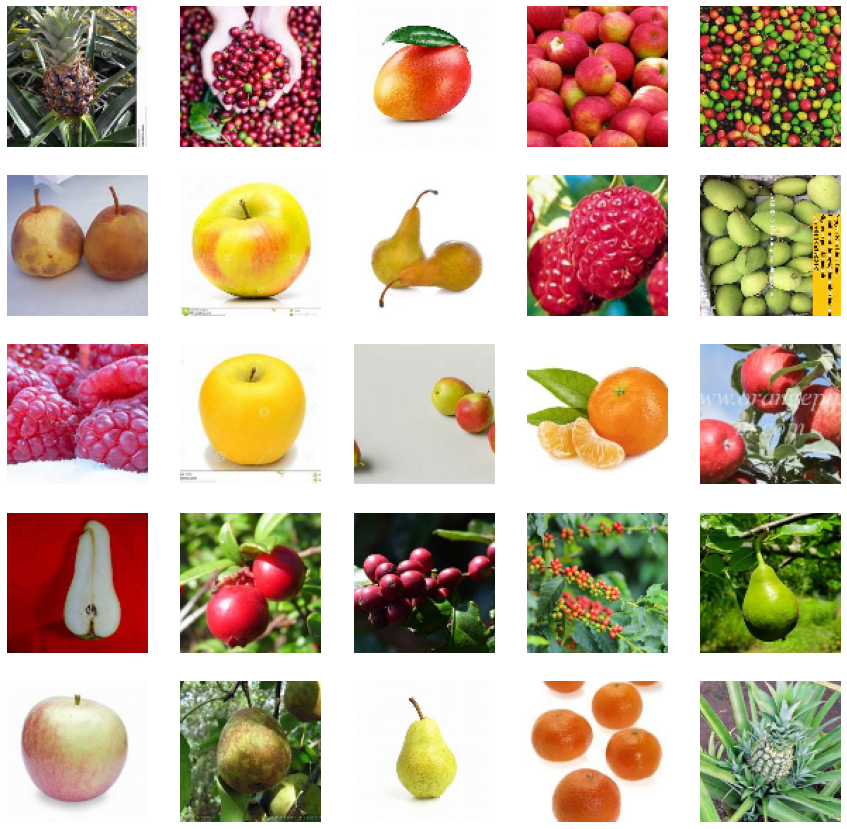

In [ ]:
plot_image_grid(fruit262_train, 5, 5, 10)

## 2. Feature Extraction

### PCA

#### Scikit-learn implementation

In [ ]:
images_train, labels_train = transform_image_to_feature_vector(fruit262_train)

In [ ]:
images_test, labels_test = transform_image_to_feature_vector(fruit262_test)

In [ ]:
pca = PCA(n_components=50)
pca_train = pca.fit_transform(images_train)
pca_test = pca.transform(images_test)

### Color Histogram

In [ ]:
fruit262_train_ch_features, fruit262_train_ch_labels, fruit262_test_ch_features, fruit262_test_ch_labels = apply_feature_extraction(get_color_histogram, fruit360_train, fruit360_test)

### Histogram of Oriented Gradients

In [ ]:
fruit262_train_hog_features, fruit262_train_hog_labels, fruit262_test_hog_features, fruit262_test_hog_labels = apply_feature_extraction(scikit_hog, fruit262_train, fruit262_test)

In [ ]:
transforms = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Resize(8),
  tv.transforms.CenterCrop(8),
  tv.transforms.Grayscale() # HOG require grayscaled image                    
])

fruit262_grayscale_train = Fruit262(fruit262_train_files, transforms=transforms)
fruit262_grayscale_test = Fruit262(fruit262_test_files, transforms=transforms)

fruit262_train_chog_features, fruit262_train_chog_labels, fruit262_test_chog_features, fruit262_test_chog_labels = apply_feature_extraction(custom_hog, fruit262_grayscale_train, fruit262_grayscale_test)

### Color Coherence Vector

In [ ]:
fruit262_train_ccv_features, fruit262_train_ccv_labels, fruit262_test_ccv_features, fruit262_test_ccv_labels = apply_feature_extraction(lambda x: get_ccv(x, 2), fruit262_train, fruit262_test)

### Local Binary Pattern

In [ ]:
fruit262_train_lbp_features, fruit262_train_lbp_labels, fruit262_test_lbp_features, fruit262_test_lbp_labels = apply_feature_extraction(lambda image: get_local_binary_pattern(image), fruit262_train, fruit262_test)

In [ ]:
transforms = tv.transforms.Compose([
  tv.transforms.ToTensor(),
  tv.transforms.Resize(25),
  tv.transforms.CenterCrop(25)                 
])

fruit262_small_train = Fruit262(fruit262_train_files, transforms=transforms)
fruit262_small_test = Fruit262(fruit262_test_files, transforms=transforms)

def custom_lbp(image):
  image_lbp = get_lbp(image)
  feature, _ = np.histogram(image_lbp, bins=256, range=(0, 256))
  return feature

fruit262_train_clbp_features, fruit262_train_clbp_labels, fruit262_test_clbp_features, fruit262_test_clbp_labels = apply_feature_extraction(lambda x: custom_lbp(x), fruit262_small_train, fruit262_small_test)

## Classifiers

In [ ]:
classifiers = {
    'random_forest': RandomForestClassifier(max_depth=50, random_state=0),
    'logistic_regression': LogisticRegression(random_state=0),
    'svm': SVC(gamma='auto')
}

In [ ]:
features = {
    'pca_scikit': {
        'train': {
            'features': pca_train,
            'labels': labels_train
        },
        'test': {
            'features': pca_test,
            'labels': labels_test
        }
    },
    'color_histogram_custom': {
        'train': {
            'features': fruit262_train_ch_features,
            'labels': fruit262_train_ch_labels
        },
        'test': {
            'features': fruit262_test_ch_features,
            'labels': fruit262_test_ch_labels
        }
    },
    'hog_skimage': {
        'train': {
            'features': fruit262_train_hog_features,
            'labels': fruit262_train_hog_labels
        },
        'test': {
            'features': fruit262_test_hog_features,
            'labels': fruit262_test_hog_labels
        }
    },
    'hog_custom': {
        'train': {
            'features': fruit262_train_chog_features,
            'labels': fruit262_train_chog_labels
        },
        'test': {
            'features': fruit262_test_chog_features,
            'labels': fruit262_test_chog_labels
        }
    },
    # 'ccv_custom': {
    #     'train': {
    #         'features': fruit360_train_ccv_features,
    #         'labels': fruit360_train_ccv_labels
    #     },
    #     'test': {
    #         'features': fruit360_test_ccv_features,
    #         'labels': fruit360_test_ccv_labels
    #     }
    # },
    'lbp_skimage': {
        'train': {
            'features': fruit262_train_lbp_features,
            'labels': fruit262_train_lbp_labels
        },
        'test': {
            'features': fruit262_test_lbp_features,
            'labels': fruit262_test_lbp_labels
        }
    },
    'lbp_custom': {
        'train': {
            'features': fruit262_train_clbp_features,
            'labels': fruit262_train_clbp_labels
        },
        'test': {
            'features': fruit262_test_clbp_features,
            'labels': fruit262_test_clbp_labels
        }
    }
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: pca_scikit, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


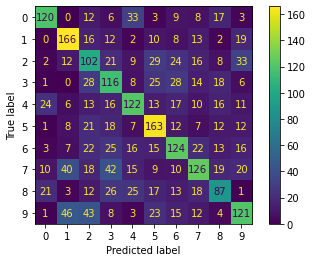

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Feature: pca_scikit, Classifier: logistic_regression


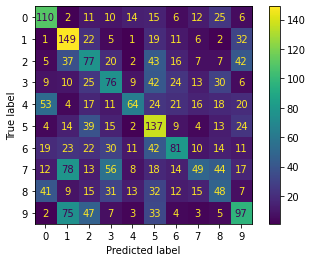

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: pca_scikit, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


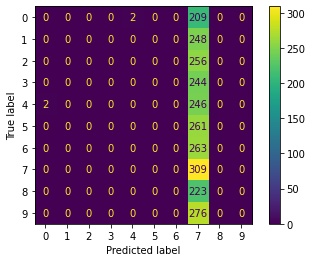

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: color_histogram_custom, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


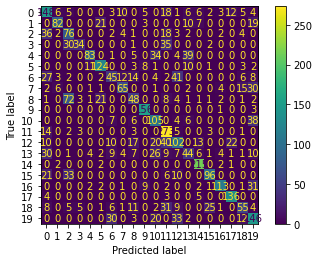

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Feature: color_histogram_custom, Classifier: logistic_regression


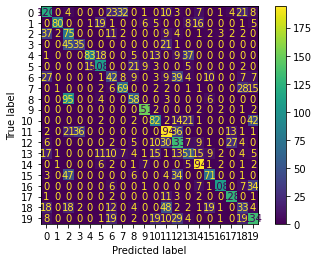

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: color_histogram_custom, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


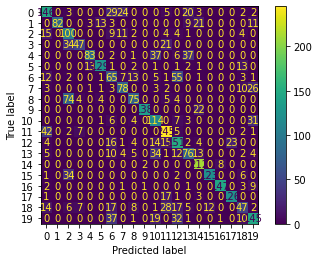

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: hog_skimage, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


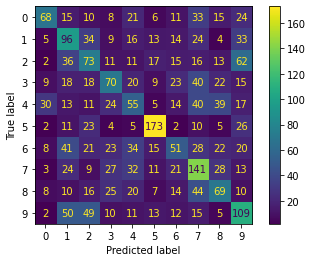

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Feature: hog_skimage, Classifier: logistic_regression


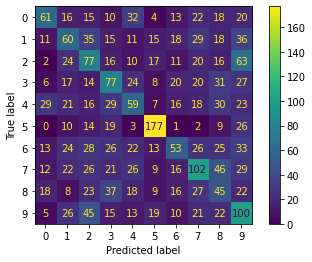

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: hog_skimage, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


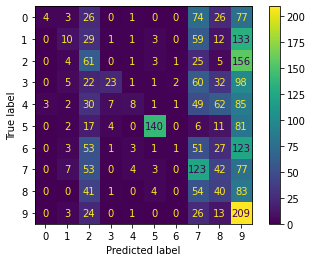

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: hog_custom, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


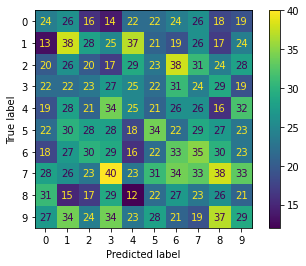

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Feature: hog_custom, Classifier: logistic_regression


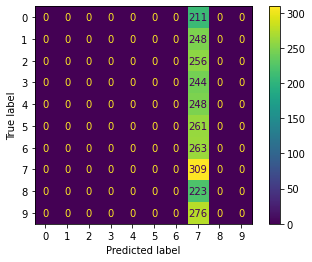

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: hog_custom, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


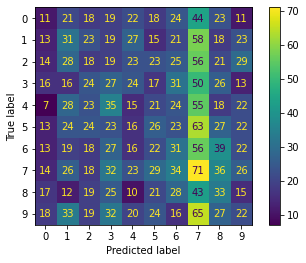

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: lbp_skimage, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


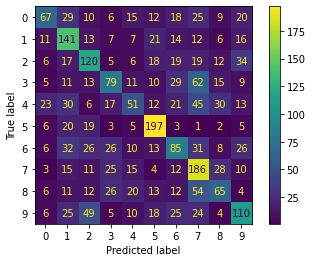

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Feature: lbp_skimage, Classifier: logistic_regression


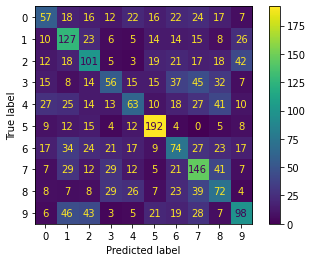

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: lbp_skimage, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


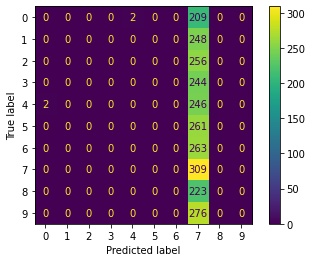

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Feature: lbp_custom, Classifier: random_forest


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


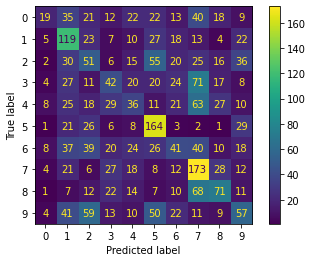

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.

Feature: lbp_custom, Classifier: logistic_regression


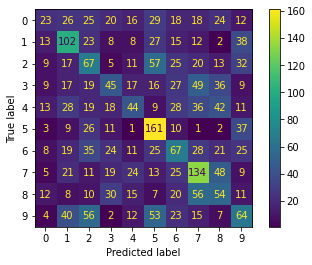

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature: lbp_custom, Classifier: svm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


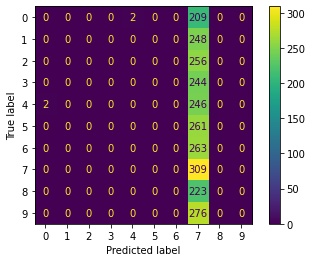

{'pca_scikit': {'random_forest': {'accuracy': 0.4911382434029145, 'f1_score': 0.4902267487348664}, 'logistic_regression': {'accuracy': 0.34974399369830644, 'f1_score': 0.3392142914315956}, 'svm': {'accuracy': 0.1217014572666404, 'f1_score': 0.026445675313215112}}, 'color_histogram_custom': {'random_forest': {'accuracy': 0.6034870641169854, 'f1_score': 0.5937037381319903}, 'logistic_regression': {'accuracy': 0.5480877390326209, 'f1_score': 0.5485011900023268}, 'svm': {'accuracy': 0.654949381327334, 'f1_score': 0.656120457251981}}, 'hog_skimage': {'random_forest': {'accuracy': 0.35643954312721543, 'f1_score': 0.35299725387028175}, 'logistic_regression': {'accuracy': 0.31941709334383617, 'f1_score': 0.318120646279958}, 'svm': {'accuracy': 0.24379677038204017, 'f1_score': 0.20388247333297255}}, 'hog_custom': {'random_forest': {'accuracy': 0.11382434029145333, 'f1_score': 0.11362210233282176}, 'logistic_regression': {'accuracy': 0.1217014572666404, 'f1_score': 0.02640853251080891}, 'svm': {

In [ ]:
results = {}

for feature_name, feature in features.items():
  results[feature_name] = {}
  correct_labels = np.array(feature['test']['labels']).T[0]

  for classifier_name, classifier in classifiers.items():
    classifier.fit(feature['train']['features'], feature['train']['labels'])
    predicted_labels = classifier.predict(feature['test']['features'])

    results[feature_name][classifier_name] = {
        'accuracy': skmetrics.accuracy_score(correct_labels, predicted_labels),
        'f1_score': skmetrics.f1_score(correct_labels, predicted_labels, average="weighted"),
    }

    print("Feature: {}, Classifier: {}".format(feature_name, classifier_name))
    skmetrics.plot_confusion_matrix(classifier, feature['test']['features'], feature['test']['labels'])
    plt.show()

print(results)    

In [ ]:
metrics = ['accuracy', 'f1_score']
results_by_metric = {}
for metric in metrics:
    results_by_metric[metric] = {}
    for feature_name, feature in features.items():
        results_by_metric[metric][feature_name] = {}
        for classifier_name, classifier in classifiers.items():
            results_by_metric[metric][feature_name][classifier_name] = results[feature_name][classifier_name][metric]


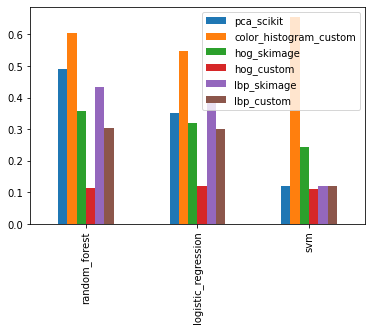

In [ ]:
pd.DataFrame(results_by_metric['accuracy']).plot.bar()

## 2. Neural Networks

### Define Models

In [ ]:
def shallow_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (5,5), stride=(2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (5,5), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(129600, output_size),
  ).train()

In [ ]:
def simp_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (3,3), stride=(2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 256, (3,3), stride=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(25600, output_size),
  ).train()

In [ ]:
def deep_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (3,3), stride=(2,2), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(9216, output_size),
  ).train()

In [ ]:
def deepwide_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (7,7), stride=(2,2), padding=(3,3)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1),  padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(2304, output_size),
  ).train()

In [ ]:
def deepwidebn_conv(output_size=3):
  return torch.nn.Sequential(
      torch.nn.Conv2d(3, 32, (7,7), stride=(2,2), padding=(3,3)),
      torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, (3,3), stride=(1,1),  padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, (3,3), stride=(1,1), padding=(1,1)),
      torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      torch.nn.MaxPool2d((2,2)),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Dropout(0.2),
      torch.nn.Linear(2304, output_size),
  ).train()

In [ ]:
def resnet_nonpretrained(output_size=3):
  return torch.nn.Sequential(
    models.resnet18(pretrained=False),
    torch.nn.Linear(1000, output_size),
    ).train()

In [ ]:
def resnet_pretrained(output_size=3):
  return torch.nn.Sequential(
    models.resnet18(pretrained=True),
    torch.nn.Linear(1000, output_size),
    ).train()

In [ ]:
#  X,y = iter(train_dataloader).next()
#  m = resnet_pretrained(output_size=len(FRUIT360_LABELS)).to('cuda')
#  with torch.no_grad():
#    pred = m(X.to('cuda'))
#    print(pred.shape)

### Train Neural Networks

In [ ]:
transf = tv.transforms.Compose([
                   tv.transforms.ToTensor(),
                   tv.transforms.Resize(192),
                   tv.transforms.CenterCrop(192),
               ])

In [ ]:
fruits_train = Fruit262(fruit262_train_files, transf)
fruits_test = Fruit262(fruit262_test_files, transf)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(fruits_train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(fruits_test, batch_size=32, shuffle=True)

In [ ]:
def train_neural_network(model, train_dataloader, test_dataloader, num_epochs=10):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
  loss = torch.nn.CrossEntropyLoss()

  train_loss = 0
  valid_loss = 0
  accuracy   = 0

  pbar = trange(num_epochs)
  for epoch in pbar:
    model.train()
    new_train_loss = 0
    for X, y in train_dataloader:
      torch.cuda.empty_cache()
      model.zero_grad()

      predicted = model(X.to('cuda'))

      L = loss(predicted, y.long().to('cuda'))

      L.backward()

      optimizer.step()

      new_train_loss += L.item()
      pbar.set_description(f'C: {L.item():.3f} L: {train_loss:.3f} V: {valid_loss:.3f} ACC: {accuracy:.3f}')

    train_loss = new_train_loss/len(train_dataloader)

    model.eval()
    new_valid_loss = 0
    new_accuracy   = 0
    with torch.no_grad():
      for X,y in test_dataloader:
        
        model.zero_grad()

        predicted = model(X.to('cuda'))
        y = y.long().to('cuda')

        L = loss(predicted, y)

        new_valid_loss += L.item()
        new_accuracy   += (predicted.argmax(1) == y).float().mean()
    accuracy   = new_accuracy  /len(test_dataloader)
    valid_loss = new_valid_loss/len(test_dataloader)

In [ ]:
m_shallow_conv = shallow_conv(output_size=len(FRUIT262_LABELS)).to('cuda')
m_simp_conv = simp_conv(output_size=len(FRUIT262_LABELS)).to('cuda')
m_deep_conv = deep_conv(output_size=len(FRUIT262_LABELS)).to('cuda')
m_deepwide_conv = deepwide_conv(output_size=len(FRUIT262_LABELS)).to('cuda')
m_deepwidebn_conv = deepwidebn_conv(output_size=len(FRUIT262_LABELS)).to('cuda')
m_resnet_nonpretrained = resnet_nonpretrained(output_size=len(FRUIT262_LABELS)).to('cuda')
m_resnet_pretrained = resnet_pretrained(output_size=len(FRUIT262_LABELS)).to('cuda')

In [ ]:
train_neural_network(m_shallow_conv, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_simp_conv, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_deep_conv, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_deepwide_conv, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_deepwidebn_conv, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_resnet_nonpretrained, train_dataloader, test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_neural_network(m_resnet_pretrained, train_dataloader, test_dataloader)

In [ ]:
path = os.getcwd() + '/drive/MyDrive/pretrained_weights/m_resnet_pretrained_fruits262.pt'
torch.save(m_resnet_pretrained.state_dict(), path)